In [1]:
from diskit.components.layer import *
from qiskit import QuantumCircuit, ClassicalRegister

from diskit_updated.circuit_remapper import *

circuit_topo = Topology()
circuit_topo.create_qmap(2, [1, 1],"qnode")
circuit_topo.qmap, circuit_topo.emap

({'qnode0': [Qubit(QuantumRegister(1, 'qnode0'), 0)],
  'qnode1': [Qubit(QuantumRegister(1, 'qnode1'), 0)]},
 {'qnode0': Qubit(QuantumRegister(1, 'com_qnode0'), 0),
  'qnode1': Qubit(QuantumRegister(1, 'com_qnode1'), 0)})

In [2]:
qregs = {}

for qpu in circuit_topo.qmap:
    reg = circuit_topo.qmap[qpu][0]._register
    qregs[reg.name] = reg
for qpu in circuit_topo.emap:
    reg = circuit_topo.emap[qpu]._register
    qregs[reg.name] = reg

qregs

{'qnode0': QuantumRegister(1, 'qnode0'),
 'qnode1': QuantumRegister(1, 'qnode1'),
 'com_qnode0': QuantumRegister(1, 'com_qnode0'),
 'com_qnode1': QuantumRegister(1, 'com_qnode1')}

## Bell state distributed circuit

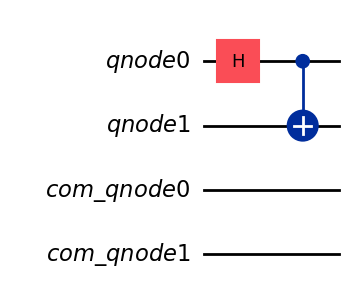

In [3]:
def get_bell_circuit():
    qregs_list = qregs.values()
    qc = QuantumCircuit(*qregs_list)
    # Qubit 0 is on QPU 1, qubit 1 on QPU 2
    qc.h(qregs['qnode0'][0])
    qc.cx(qregs['qnode0'][0], qregs['qnode1'][0])

    return qc

qc = get_bell_circuit()
qc.draw(output='mpl')

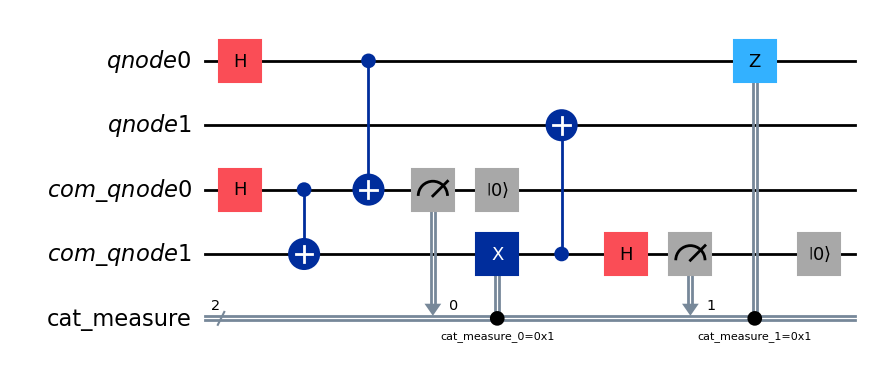

In [4]:
remapper = CircuitRemapper(circuit_topo)
dist_circ = remapper.remap_circuit(qc)

measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
dist_circ.add_register(measure_reg_q0)
dist_circ.add_register(measure_reg_q1)
dist_circ.barrier()
dist_circ.measure(qregs['qnode0'], measure_reg_q0)
dist_circ.measure(qregs['qnode1'], measure_reg_q1)
dist_circ.draw(output='mpl')

In [5]:
from qiskit import transpile
from qiskit_aer import Aer

qc = get_bell_circuit()
measure_reg_q0 = ClassicalRegister(len(qregs['qnode0']), name="measure_qnode0")
measure_reg_q1 = ClassicalRegister(len(qregs['qnode1']), name="measure_qnode1")
qc.add_register(measure_reg_q0)
qc.add_register(measure_reg_q1)
qc.barrier()
qc.measure(qregs['qnode0'], measure_reg_q0)
qc.measure(qregs['qnode1'], measure_reg_q1)

backend = Aer.get_backend('statevector_simulator')
transpiled_qc = transpile(qc, backend)
job = backend.run(transpiled_qc, shots=3000)

counts = job.result().get_counts()
counts

KeyboardInterrupt: 

In [ ]:
backend = Aer.get_backend('statevector_simulator')
transpiled_qc = transpile(dist_circ, backend)
job = backend.run(transpiled_qc, shots=3000)

counts = job.result().get_counts()

measurement_final_results = {}
for key, value in counts.items():
    result_key = key[:3]
    if result_key in measurement_final_results:
        measurement_final_results[result_key] += value
    else:
        measurement_final_results[result_key] = value

measurement_final_results

{'1 1': 1493, '0 0': 1507}